In Google Colab default Tensorflow is still 1.15.0, but I'm using some tf2 features


In [0]:
import tensorflow as tf
if (tf.__version__=='1.15.0'):
  !pip uninstall tensorflow
  !pip install -U tensorflow-gpu==2.0.0

#after you have to restart the runtime, if run in colab

In the first lines, we upload the zip file.

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import drive
drive.mount('/content/drive')


#Give it the directory to unzip it from (or upload it manually and skip this)


!unzip -uq "/content/drive/My Drive/POLIMI/AN2DL/DL.zip" -d "/content/"

Then, we import the necessary libraries, set the seed, set the directory and monitor the GPUs

In [3]:
import os
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import numpy as np
import datetime



# Set the seed for easy reproducibility
SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

# Set GPU memory growth 
# Allows to only as much GPU memory as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


We build the generators and decide the training/validation split, we augment the training data


In [0]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True   

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(
                                        rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1./255,
                                        preprocessing_function=None,
                                        data_format='channels_last',
                                        validation_split=0.2,    
                                       )
    #Augmentation data parameters don't seem to matter much
else:
    train_data_gen = ImageDataGenerator(rescale=1./255)

#here I create the validation data generator
valid_data_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

We create the generators to read the images from our directory, set batch size, image dimensions and set the classes


In [5]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, '/content/Classification_Dataset')

# Batch size
bs = 8 

# img shape
img_h = 256   #height of the incoming images
img_w = 256   #width of the incoming images

num_classes = 20

classes = [ 'owl',
            'galaxy',
            'lightning',
            'wine-bottle',
            't-shirt',
            'waterfall',
            'sword',
            'school-bus',
            'calculator',
            'sheet-music',
            'airplanes',
            'lightbulb',
            'skyscraper',
            'mountain-bike',
            'fireworks',
            'computer-monitor',
            'bear',
            'grand-piano',
            'kangaroo',
            'laptop'
]

training_dir = os.path.join(dataset_dir, 'training')
valid_dir = os.path.join(dataset_dir,'training')
test_dir = os.path.join(dataset_dir,'test')

train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=bs,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True, #it's nice to have them shuffled
                                               subset='training',
                                               seed=SEED)  


# targets are directly converted into one-hot vectors

# Validation 
valid_gen = valid_data_gen.flow_from_directory(
                                                valid_dir, #same as training directory
                                                batch_size=bs,
                                                classes=classes,
                                                class_mode='categorical',
                                                shuffle=True, #even in validation, it doesn't change much
                                                              #it's better to let it see diverse data at each epoch 
                                                subset='validation',
                                                seed=SEED) # set as validation data

#With more time, it would make sense to cross-validate in order to 
# 1) tune hyperparameters 2) make the model see all the validation data and
# find a average model/use them as voters in an ensemble model 

Found 1247 images belonging to 20 classes.
Found 307 images belonging to 20 classes.


Now we can use the defined generators. Set on repeat in order to reuse the same images.

In [0]:

#We now finally get the training and validation datasets from the generators

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

# Repeat
valid_dataset = valid_dataset.repeat()

Then, we look at some images. This is useful to see whether our augmentation techniques make sense and whether the dataset was imported correctly


(8, 256, 256, 3)

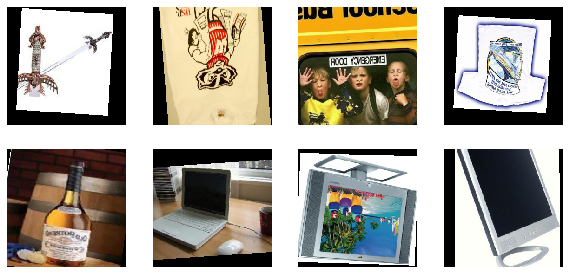

In [0]:

import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(bs):
      ax = plt.subplot(bs/2,bs/2,n+1)
      plt.imshow(image_batch[n])
      #plt.title(classes[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)
image_batch.shape

Now we can build our neural network. In this final attempt we will use only 3 convolutional neural networks to build an ensemble method, with 2 different famous architectures, downloading the weights from Keras. I've experimented with other networks (my handcrafted neural net, VGG16, VGG19, Mobilenet... and for a lot of time with inception and resnet), but for the final model I've selected only the best networks, which scored consistently over 0.97 in validation accuracy (over all dataset). I define a Model_run function and then train the 3 networks.

In [0]:
#TRANSFER

def Model_run(architecture, freezing, mode, verbose):
  
  tmodel = tf.keras.Sequential()


  if (architecture == "resnet"):
    arch = tf.keras.applications.resnet_v2.ResNet152V2(include_top=False, weights='imagenet',classes=20,input_shape=(img_h, img_w, 3))
    freeze_until = freezing
    for layer in arch.layers[:freeze_until]:
          layer.trainable = False

  if (architecture == "inception",):
    arch = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))
    freeze_until = freezing # ottenuto facendo alcune prove (considerando di non allenare mai più di 10M parametri)
    for layer in arch.layers[:freeze_until]:
          layer.trainable = False

  if (architecture == "inceptionresnet"):
    arch =  tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))
    freeze_until = freezing
    for layer in arch.layers[:freeze_until]:
          layer.trainable = False
  
  if (architecture == "densenet"):
    arch =  tf.keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))
    freeze_until = freezing
    for layer in arch.layers[:freeze_until]:
          layer.trainable = False

  tmodel.add(arch)

  tmodel.add(tf.keras.layers.GlobalAveragePooling2D(data_format=None))
  tmodel.add(tf.keras.layers.Dropout(0.5))

  #By thorough experimentation and looking at famous architectures, I've decided to go with 
  #a global average pooling layer before the last dense layer, instead of stacking 
  #dense layers. This reduces the number of parameters to be trained and obtains equally good results,
  #as we've already got plenty of nonlinearity in the convolutional part

  tmodel.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

  # Visualize created model as a table
  #tmodel.summary() useful only when selecting how many layers to freeze

  # Optimization params

  # Loss
  loss = tf.keras.losses.CategoricalCrossentropy() #easy choice

  # learning rate 
  lr = 5e-4   #after a lot of trial and error, I've found this lr to be quick enough to train quickly 
  #without oscillating too much around the final solution

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)  #the best in my trials, fast without losing precision


  # Validation metrics

  metrics = ['accuracy'] #no particular features or imbalances to privilege another metric


  # Compile Model
  tmodel.compile(optimizer=optimizer, loss=loss, metrics=metrics)


  #We add an earlystopping callback and, most importantly, a LR adapter callback,
  # which helps us to get into the right minimum. 

  tmodel.build(input_shape=(None, img_h, img_w, 3))
  
  if (mode == 'train'):

    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7,restore_best_weights=True)
    LR_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

    tmodel.fit(x=train_dataset,
            epochs=150,  #normally stops much earlier
            steps_per_epoch=len(train_gen), #I haven't found a great difference in choosing different values
            validation_data=valid_dataset,
            validation_steps=len(valid_gen), #idem
            callbacks=[es_callback,LR_adapter_callback,],
            verbose = verbose) #I like to monitor the accuracy during training live ()
            
    tmodel.save(os.path.join('/content/drive/My Drive/POLIMI/AN2DL/Lab/Retine/'+architecture+'1233.h5'))
    return tmodel

  # In this mode, it's possible to tune hyperparameters and get the validation scores through for cycles 
  if (mode == 'hparam'):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4,restore_best_weights=True)
    LR_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0)
    
    tmodel.fit(x=train_dataset,
            epochs=150,  #normally stops much earlier
            steps_per_epoch=len(train_gen), #I haven't found a great difference in choosing different values
            validation_data=valid_dataset,
            validation_steps=len(valid_gen), #idem
            callbacks=[es_callback,LR_adapter_callback,],
            verbose = verbose) #I like to monitor the accuracy during training live ()

    return tmodel,tmodel.evaluate(valid_dataset,steps=307,verbose=0)

  else:
    return tmodel

  tmodel.save(os.path.join('/content/drive/My Drive/POLIMI/AN2DL/Lab/Retine/'+architecture+'1233.h5'))





Here I have the 3 networks. Even though it's probably not relevant, I've used some diverse networks as I thought their different architecture might have made them learn features in a different way. I also included two inception_resnet networks, as they were solidly the best performers and, even though they got the same accuracy, as I checked for all the best nets in a Python script (which I didn't send, but it can be given if needed) where they classified differently, I've found they differed in 8 cases. So, they seemed different enough to be considered.
In the last version, I've actually ditched resnet and inception, as their inferior performance was hindering the vote of the whole ensemble

In [0]:
#inception = Model_run("inception", 285, 'train', 0)
#resnet = Model_run("resnet", 285, 'train',0)

#these are the nets in the final ensemble method which scored 0.99 on the test set 

densenet = Model_run("densenet", 600, 'train', 0)
inceptionresnet1 = Model_run("inceptionresnet", 750, 'train', 0)
inceptionresnet2 = Model_run("inceptionresnet", 700,'train', 0)

#all the freezing points have been found heuristically by trying some different values and always training <10M parameters

74842112/74836368 [==============================] - 6s 0us/step

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
219062272/219055592 [==============================] - 14s 0us/step

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.


In [8]:
"""
densenet = tf.keras.models.load_model('/content/drive/My Drive/POLIMI/AN2DL/Lab/Retine/'+'Densenet600.h5')
print('densenet is here bringing good cheer')
densenet1 = tf.keras.models.load_model('/content/drive/My Drive/POLIMI/AN2DL/Lab/Retine/'+'densenet1233.h5')
print('densenet the more the merrier')
inceptionresnet = tf.keras.models.load_model('/content/drive/My Drive/POLIMI/AN2DL/Lab/Retine/'+'Inception_Resnet.h5')
inceptionresnet2 = tf.keras.models.load_model('/content/drive/My Drive/POLIMI/AN2DL/Lab/Retine/'+'Inception_Resnet_2.h5')
print('Fusion! Inceptionresnet is born')
inceptionresnet1 = tf.keras.models.load_model('/content/drive/My Drive/POLIMI/AN2DL/Lab/Retine/'+'inceptionresnet1233.h5')
"""

#uploading nets (not necessary)

densenet is here bringing good cheer
inceptionresnet the more the merrier


In [9]:

val0=inceptionresnet.evaluate(valid_dataset,steps=307,verbose=1)
val1=inceptionresnet2.evaluate(valid_dataset,steps=307,verbose=1)
val2=densenet.evaluate(valid_dataset,steps=307,verbose=1)
#val3=densenet1.evaluate(valid_dataset,steps=307,verbose=1)  #these were trials mixing nets trained on different seeds 
#val4=inceptionresnet1.evaluate(valid_dataset,steps=307,verbose=1)


#I check the accuracy on the whole validation set in order to assign the score when I do a weighted voting

307/307 [==============================] - 37s 119ms/step - loss: 0.0432 - accuracy: 0.9872


([0.045444228614071186, 0.9867823],
 [0.08938369832634611, 0.97433776],
 [0.12105837473978558, 0.9606788],
 [0.043235424905437705, 0.98716885])

Here I have tried with many different voting strategies.

First, plain majority voting, which selects the class most voted by the majority of the nets (the ordering of the 'ass' variable which is passed to it
ahould be from 'most reliable' to 'least reliable' in order to solve drawing situations optimally).

Then, Borda voting. Every net assigns a score (1-20) to every class based on the posterior probability density of the classes, with 20 being the most probable and 1 the least probable. Then, all the nets' scores are summed and the highest is selected.

Actually, in the end, I will use a weighted Borda voting, where every net 'votes' with more power if it has a higher validation/test score, where the power is given by the accuracy on the validation/test set. This is essentially really similar to plain Borda, but the ties are broken through the validation scores




In [0]:
from PIL import Image
import itertools

final_path = os.path.join(dataset_dir, 'test')
image_filenames = next(os.walk(final_path))[2]  #I get the names of the images

results = {} #empty dictionary for results, which I will then make into a csv file

#m_assembly = [inceptionresnet,inceptionresnet2,densenet,resnet,inception]

m_assembly = [inceptionresnet,inceptionresnet2,densenet] #list of the nets I'm using


#m_scores = [val0[1],val1[1],val2[1],val3[1],val4[1]]
m_scores = [val1[1],val2[1],val3[1],val4[1]]

def majority_voting(ass,res):
  pred_vec = np.zeros(len(ass),dtype=int) # important to have int in order for bincount to work
  for j in range(len(pred_vec)):
    pred_vec[j] = np.argmax(res[j])
  return np.argmax(np.bincount(pred_vec))

#simple implementation of the borda
def borda(ass,res):
  voting_vector = np.zeros(len(classes),dtype=int)
  for i in range(len(ass)):
    count=len(classes)
    for j in range(len(classes)): # i modify the local vector by setting to 0 the already scored best prediction and loop through
      m=np.argmax(res[i]) 
      voting_vector[m] = voting_vector[m] + count
      res[i][0][m] = 0
      count = count - 1
  return np.argmax(voting_vector)

#weighted borda takes an additional parameter based on the validation score
def weighted_borda(ass,res,wiseness):
  voting_vector = np.zeros(len(classes),dtype=float)
  for i in range(len(ass)):
    count=len(classes)
    for j in range(len(classes)):
      m=np.argmax(res[i]) 
      voting_vector[m] = voting_vector[m] + count*wiseness[i]
      res[i][0][m] = 0
      count = count - 1
  return np.argmax(voting_vector)
 



In [0]:
#now for every image, we get it in the right format in order to feed it to the neural network 

#count=0
for image_name in image_filenames:
  
   img = Image.open(final_path+'/'+image_name).convert('RGB')
   img=img.resize((img_h,img_w))
   img_array = np.array(img)
   img_array = np.expand_dims(img_array, 0)
   img_array = np.true_divide(img_array,255)
   
   result = []
   for i in range(len(m_assembly)):
      result.append(m_assembly[i].predict(img_array) )
      
   #prediction = majority_voting(m_assembly,result)
   #prediction = borda(m_assembly,result)
   prediction = weighted_borda(m_assembly,result,m_scores) #I've selected weighted borda as my final choice
   
   results[image_name] = prediction
   #print(count)
   #count = count + 1

Then, I define the create_csv function and get my results in csv format in the wanted directory.


In [0]:
import os
from datetime import datetime

def create_csv(results, results_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [0]:
create_csv(results,'/content/drive/My Drive/POLIMI/AN2DL/Lab')

In the end, there is still one thing which would probably greatly enhance performance, namely cross-validating (5-folds, ideally), in order to have the networks look at all the dataset and therefore further enhance the power of the ensemble method.

I have not included the handcrafted neural networks' work, as it was not used in the final model. There, I had proceeded similarly, trying to select the right number of conv+pooling blocks and dense layers.

I also tried to test the model on all the dataset, but not having a validation loss/accuracy to use in order to adapt the learning rate (having to schedule it with an exponentially decaying scheduler) and early stop, it ended up being less precise than if trained on less data.

I have tried cross-validating in the other notebook. However, the training is much slower as I have a bottleneck in the file injection procedure and it crashed multiple times for unknown reasons (RAM was not even nearly filled).
I attach it anyways, as I think normally it should work.
Ideally then, for the ensemble method, I would use the CV models, which could help reaching a higher accuracy on the test set.

A big limitation on the ensemble method is, though, that uploading the models from a .h5 file, takes a lot of memory (and with more than 5 nets it fills Colab's 25 G memory). It would be good, for the future, to download the csv file predictions or, even better, store all the posteriors of the various nets instead of keeping in memory the networks and use those to compute the final predictions.